## To begin, let's connect to the Azure SQL Database and query some data.

In [9]:
import pyodbc
import pandas as pd
import json

# with open('login_creds.json') as f:
#     login = json.load(f)

# conn_str = (
#     r'Driver=SQL Server;' +
#     r'Server={};'.format(login['Server']) +
#     r'Database={};'.format(login['Database']) + 
#     'UID={};'.format(login['Username']) +
#     'PWD={};'.format(login['Password'])
#     )
# cnxn = pyodbc.connect(conn_str)

In [10]:
# def query_db(query, connection):

#     cursor = connection.cursor()
#     cursor.execute(query)
#     rows = []
#     for row in cursor.fetchall():
#         rows.append(row)
#     columns = [column[0] for column in cursor.description]

#     df = pd.DataFrame.from_records(rows, columns = columns)
    
#     return df

In [22]:
# sale = query_db("SELECT f.*, d.FullDate FROM FactSales f JOIN DimDate d on d.datekey = f.datekey", cnxn)
# customer = query_db("SELECT * FROM DimCustomer", cnxn)

# sale.to_csv('Sales.csv', index = False)
# customer.to_csv('DimCustomer.csv', index = False)

In [26]:
with open('Sales.csv', errors = 'ignore') as f:
    sale = pd.read_csv(f)
with open('DimCustomer.csv', errors = 'ignore') as f:
    customer = pd.read_csv(f).drop('Unnamed: 0', axis = 1)

### Now, the data from these tables is in memory, stored in a dataframe. 

We can work with this table similarly to how you might work with a table in SQL, but with python and a package called pandas!


...

## On to the business problem!
### Can we use data science and build a model to help us determine how to best segment out customers?

First, let's work on manipulating our data so that we can pass information on our customers to a model that will help us create these segments.

A common, simple technique to summarize customer purchasing behavior for further analysis (like segmentation) is referred to as RFM- recency, frequency, and magnitude of a customer's purchases. 

* **Recency:** days since last sale, compared the overall most recent sale across all customers
* **Frequency:** count of unique days a sale occurred
* **Magnitude:** total sum of sale dollars

We can think of RFM as a way to boil down everything we have in the data about a customer's behavior into a few simple, but valuable, pieces of information. We're helping our model down the road by synthesizing this information ahead of time because we as humans with our human expertise know that it'll be important when segmenting our customers. This is a very simple example of **feature engineering**- the process by which humans help models discover what's important in data by applying their domain knowledge to give the model a transformed version of the data!

In [16]:
sale['FullDate'] = pd.to_datetime(sale['FullDate'], infer_datetime_format=True) 

# groupby - looks familiar? :)
recency = sale.groupby('CustomerKey')['FullDate'].max().rename('MostRecentPurchase').reset_index()
recency['DaysSinceLastPurchase'] =  recency.MostRecentPurchase.max() - recency.MostRecentPurchase
recency['DaysSinceLastPurchase'] = recency.DaysSinceLastPurchase.astype(str).str[:2].astype(int)

In [20]:
frequency = sale.groupby('CustomerKey')['DateKey'].nunique().rename('CountofSales').reset_index()

In [26]:
magnitude = sale.groupby('CustomerKey')['TotalSaleAmt'].sum().rename('TotalSaleDollars').astype(float).reset_index()

In [27]:
# Logic for buckets based on quantiles of these values
# 1 is the worst & 5 is the best
recency['DaysSinceLastPurchaseBucket'] = pd.qcut(recency['DaysSinceLastPurchase'], 5, labels=[5, 4, 3, 2, 1])
frequency['CountSalesBucket'] = pd.qcut(frequency['CountofSales'], 5, labels=[1, 2, 3, 4, 5])
magnitude['TotalSalesBucket'] = pd.qcut(magnitude['TotalSaleDollars'], 5, labels=[1, 2, 3, 4, 5])

In [29]:
customer_rfm = recency.merge(frequency).merge(magnitude)

From here, we'll try to segment our customers based on these bucketed values of R, F, & M so that we can create actionable groups of similar customers to pass along to our marketing department. 

What type of problem is this? Classification, regression, or unsupervised?

.

.

.

.

.

.

.

.

.

.

.

### Unsupervised! 

We aren't comparing against a "right" answer here- just looking to explore and find some patterns in our data.


### Exploring clustering methods

To begin creating customer segments, let's pick a clustering algorithm to try out, and then do some analysis into how many segments we'd like create. Some algorithms pick the number of segments for you as they cluster the data points, and others require you to specify the number of segments you want the algorithm to find ahead of time. 

Here, we'll try out a K-Means clustering algorithm, which does require you to specify cluster number (n_clusters, below) ahead of time!




There are a few factors that can help inform us in selecting n_clusters. One of the main factors is domain knowledge and usability! 

If I'm a marketing director, would I expect there to be 1,534 distinct segments of customers in my base that I can individually market to? Maybe? If there were, could I reasonably do anything about that? I doubt it! I think I have the mental capacity and budget to keep track of maybe 3-10 segments (for example).

Another helpful way to decide the number of clusters is to try fitting the algorithm with a bunch of values of n_clusters, and then compare measurements on the clusters between these values. How tightly knit and well defined are my clusters when I select 2 as the number? How about 3? 4? The goal here is to find the smallest number of clusters that are still reasonably tight-knit. This method is commonly referred to as the **elbow method**! When you plot a measure of tight-knit-ness against the number of clusters, you find a point where you stop making a lot of gains in tight-knit-ness and you're just adding clusters to add clusters. This looks like an elbow in the graph! Where the elbow falls, this number of clusters might be a good idea to try.


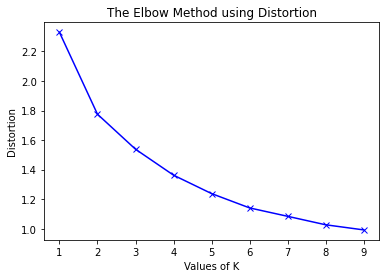

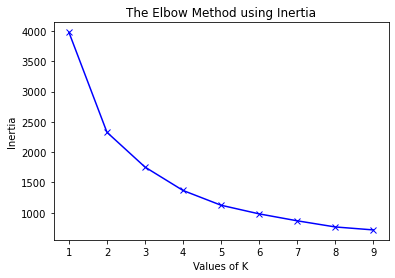

In [50]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

X = customer_rfm[['DaysSinceLastPurchaseBucket', 'CountSalesBucket', 'TotalSalesBucket']]

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model for the given value of K
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()
# Distortion: Calculated as the average of the squared distances from the cluster centers of the respective clusters. 
# Typically, the Euclidean distance metric is used.

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()
# Inertia: Sum of squared distances of samples to their closest cluster center.

## Elbow seems to appear around K = 3 or 4 (very very loosely!), indicating these might be a good fit for number of clusters.

## Note that our data is largely randomized and they're aren't concrete patterns to discover like in real customer data. 
# This is just for example's purposes :)

### Let's try it out!
 
 
Let's explore what our clusters look like if we go with 3 clusters, and then 4!

We can fit the algorithm, use the fitted model to assign our customer records to clusters, and explore the characteristics of each cluster.

Below, we're just defining a simple function that will help us do this exploration- when passed a cluster number and a dataframe with records and cluster assignments, print out the median feature values for the customers that fell into that cluster.

In [43]:
def print_rfm(cluster_assignment, df):
    df = df[df.KMeansClusterAssignment == cluster_assignment]
    med_rec = df.DaysSinceLastPurchaseBucket.astype(int).median()
    med_rec_val = df['DaysSinceLastPurchase'].astype(int).median()
    med_freq = df.CountSalesBucket.astype(int).median()
    med_freq_val = df['CountofSales'].astype(int).median()
    med_mag = df.TotalSalesBucket.astype(int).median()
    med_mag_val = df['TotalSaleDollars'].astype(int).median()
    print('Cluster #{}'.format(cluster_assignment))
    print('Median Recency Quantile:   {}'.format(med_rec))
    print('Median Frequency Quantile: {}'.format(med_freq))
    print('Median Magnitude Quantile: {}'.format(med_mag))
    
    print('Median Recency:   {} days'.format(med_rec_val))
    print('Median Frequency: {} purchases'.format(med_freq_val))
    print('Median Magnitude: ${:,}'.format(med_mag_val))
    print('\n')

In [45]:
kmeanModel = KMeans(n_clusters=3).fit(X)
customer_rfm['KMeansOutput'] = kmeanModel.transform(X).tolist()
customer_rfm['KMeansClusterAssignment'] = customer_rfm.KMeansOutput.apply(lambda x: x.index(max(x)) + 1)

result = [print_rfm(cluster_assignment = c, df = customer_rfm) for c in [1,2,3]]

Cluster #1
Median Recency Quantile:   2.0
Median Frequency Quantile: 2.0
Median Magnitude Quantile: 2.0
Median Recency:   13.0 days
Median Frequency: 90.0 purchases
Median Magnitude: $240,633.0


Cluster #2
Median Recency Quantile:   5.0
Median Frequency Quantile: 2.0
Median Magnitude Quantile: 2.0
Median Recency:   1.0 days
Median Frequency: 94.0 purchases
Median Magnitude: $260,550.0


Cluster #3
Median Recency Quantile:   3.0
Median Frequency Quantile: 4.0
Median Magnitude Quantile: 4.0
Median Recency:   7.0 days
Median Frequency: 104.0 purchases
Median Magnitude: $306,205.0




### Exploring the segments

Below, using 4 clusters, we see some distinctions between clusters in terms of the typical recency, frequency, and magnitude of the customers in the cluster. 

It looks like **cluster #1** is one of the most recent, but has the least frequent and smallest total purchases. This is where we have to step back in and put on our marketing director hats. How might we describe this group of customers? How might we market to them?

**Cluster #2** seems pretty middle-of-the-road in all aspects. What might this say about them?

How about **cluster #3**? We see high values here across the board. VIP, anyone?

And **cluster #4**? High frequency of purchases and high total spend. Big dogs? But they have one of the lowest values for recency for a segment. These might be customer who used to be "VIP"s, but have since expired from the customer base or maybe found a different provider to do business with. 


In [46]:
kmeanModel = KMeans(n_clusters=4).fit(X)
customer_rfm['KMeansOutput'] = kmeanModel.transform(X).tolist()
customer_rfm['KMeansClusterAssignment'] = customer_rfm.KMeansOutput.apply(lambda x: x.index(max(x)) + 1)

result = [print_rfm(cluster_assignment = c, df = customer_rfm) for c in [1,2,3,4]]

Cluster #1
Median Recency Quantile:   4.0
Median Frequency Quantile: 1.0
Median Magnitude Quantile: 1.0
Median Recency:   3.0 days
Median Frequency: 85.0 purchases
Median Magnitude: $223,240.5


Cluster #2
Median Recency Quantile:   2.0
Median Frequency Quantile: 2.0
Median Magnitude Quantile: 2.0
Median Recency:   14.0 days
Median Frequency: 91.0 purchases
Median Magnitude: $245,664.0


Cluster #3
Median Recency Quantile:   4.0
Median Frequency Quantile: 4.0
Median Magnitude Quantile: 4.0
Median Recency:   4.0 days
Median Frequency: 102.0 purchases
Median Magnitude: $295,305.0


Cluster #4
Median Recency Quantile:   1.0
Median Frequency Quantile: 4.0
Median Magnitude Quantile: 4.0
Median Recency:   18.0 days
Median Frequency: 105.0 purchases
Median Magnitude: $305,100.0




### What's in a name?

After exploring the clusters, maybe we can boil down what we've noticed about these groups of customers into some friendly segment names that make it more clear what types of customers fall into each segment, and how these segments seem to have been formed. 

In [47]:
# Assign basic profile names to clusters

customer_rfm['SegmentName'] = ''
customer_rfm.loc[customer_rfm.KMeansClusterAssignment == 1, 'SegmentName'] = 'New'
customer_rfm.loc[customer_rfm.KMeansClusterAssignment == 2, 'SegmentName'] = 'Potential'
customer_rfm.loc[customer_rfm.KMeansClusterAssignment == 3, 'SegmentName'] = 'Loyal'
customer_rfm.loc[customer_rfm.KMeansClusterAssignment == 4, 'SegmentName'] = 'At Risk'

In [49]:
# Breakdown of customers by cluster
((customer_rfm.SegmentName.value_counts() / customer_rfm['CustomerKey'].nunique()) * 100).apply(lambda x: "{0:.1f}%".format(x))

Loyal        42.4%
Potential    31.5%
At Risk      13.4%
New          12.7%
Name: SegmentName, dtype: object

## Next steps

It depends on our stakeholder's requirements and specific use for these segments, but from here, we can imagine that if a marketing director was looking for a succint way to reference groups of customers, target promotional materials, or maybe offer coupons or discounts to a portion of the customer base, we're **on the right track** to empowering them to do so. 

Maybe they could even use our clustering model and segments to start tracking movement between the segments over time (i.e. Why did 5% of my Loyal customers move to At Risk last month?) or overlaying demographic or geographic information to the segments to understand more about these types of customers. Maybe we could include these features in the clustering and expand on just using RFM, or try out different algorithms, or numbers of segments.

We're just scratching the surface!


### What's missing here?

So we're done, right? Our segments that live in this little notebook are ready to create value for the business? 

Not quite! We're just scratching the surface when it comes to the analysis and clustering from a technical standpoint, but more importantly, we haven't done anything to actually make these segments available to the people who matter.
We've been able to find something valuable in doing this exercise- but we haven't captured anything for the business yet. If we're happy with these, what might we have to do next to actually empower action and allow these segments to be consumed and used by the business?